In [26]:
# Predicting house prices: a regression example

# Load Boston Housing dataset
from keras.datasets import boston_housing

# 404 training samples and 102 test samples with categories such as crime rate, etc
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [27]:
# Normalizing the data

# Feature-wise normalization is used before its fed into a neural network because so that 
# the values aren't wildly different ranges and it takes less time to train the network

# For each feature in the input data (column in matrix), we subtract the mean of the feature and divide by standard deviation
# so that the feature is centered around 0 and has a unit standard deviation

mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [28]:
# Model definition
from keras import models
from keras import layers

# Use small network to mitigate overfitting due to few samples
# Less training data we have, the worse overfitting will be
def build_model():
    model = models.Sequential()

    # Two hidden layers with 64 units each
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))

    # Layer with a single unit and no activation (linear layer)
    model.add(layers.Dense(1))

    # compile model with mean squared error - square of difference between predictions and targets
    # mean absolute error is absolute value of different between predictions and targets
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model

In [29]:
# K-fold validation with 100 epochs
import numpy as np

# Split available data into 4 partitions
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)

    # Prepares training data: data from all other partitions
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    # Build model
    model = build_model() 

    # Trains model
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    
    # Evaulates model on validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [30]:
print(all_scores)
print(np.mean(all_scores))

[1.9025975465774536, 2.364314556121826, 2.987734317779541, 2.526278018951416]
2.445231109857559


In [31]:
# K-fold validation with 500 epochs
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)

    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model() 

    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [32]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
average_mae_history

[4.237994909286499,
 3.458185076713562,
 3.138670563697815,
 2.8758928179740906,
 2.734860062599182,
 2.720849931240082,
 2.638824164867401,
 2.5919625759124756,
 2.7037163376808167,
 2.5030540227890015,
 2.7020281553268433,
 2.5585750341415405,
 2.701566696166992,
 2.484416663646698,
 2.468679964542389,
 2.57683402299881,
 2.575345039367676,
 2.4314064979553223,
 2.3832472562789917,
 2.6758697032928467,
 2.4750855565071106,
 2.4428725838661194,
 2.41914439201355,
 2.5124323964118958,
 2.5734963417053223,
 2.374728113412857,
 2.3797370195388794,
 2.350535809993744,
 2.3181503117084503,
 2.5128079056739807,
 2.3321467638015747,
 2.387806326150894,
 2.3835620880126953,
 2.5000964403152466,
 2.5226208567619324,
 2.327978789806366,
 2.4476650953292847,
 2.3483861088752747,
 2.4302339255809784,
 2.457343876361847,
 2.3157595098018646,
 2.403753340244293,
 2.428204894065857,
 2.3926053643226624,
 2.312757134437561,
 2.336973488330841,
 2.2435113191604614,
 2.3926836252212524,
 2.341016530990

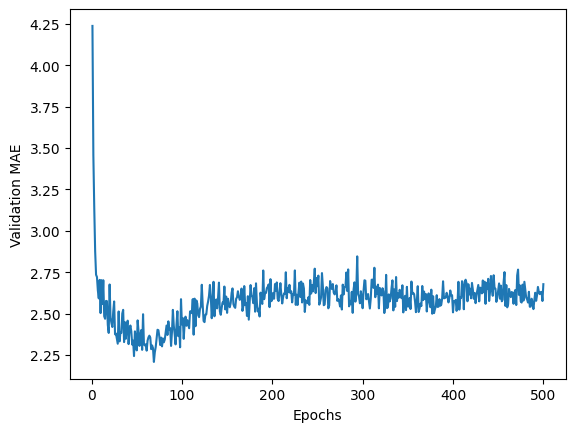

In [33]:
# Plotting validation scores
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

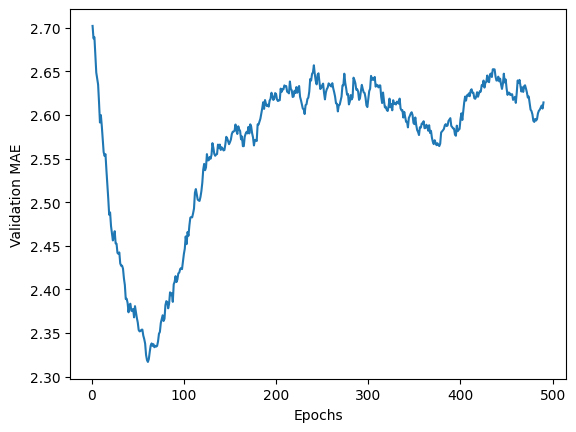

In [34]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

In [35]:
# Train final model
model = build_model() 

# Trains model on the entirety of the data
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

test_mae_score

4/4 [==============================] - 0s 2ms/step - loss: 18.7289 - mae: 2.7249


2.7248871326446533